# Deep Learning




## Tensorflow 

refs:

https://www.tensorflow.org/tutorials/estimators/cnn

### Install

https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html

```sh
conda create -n tensorflow_cpu pip python=3.6

source activate tensorflow_cpu

# install tensorflow 
pip install --ignore-installed --upgrade tensorflow==1.9

# test instalations
python -c "import tensorflow as tf; print(tf.__version__)"

# Save enviroment for later use
conda env export > tensorflow_cpu.yml
conda list -e > requirements.txt

# actvate the enviroment in jupyter notebook
# RUN outisde the env tensorflow
# In caseyou want to use the same terminal you need to run deactivate
deactivate

# install ipykernel
conda install -c anaconda ipykernel 

# install env in jupyter notebook. NOW youcan select this env n change kernel tab
python -m ipykernel install --user --name tensorflow_cpu --display-name "Python (tensorflow)"
```


In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
#from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

slim = tf.contrib.slim

%matplotlib inline
np.random.seed(1)

print(tf.__version__)

/home/leandroohf/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.10.0


### Basics 

* define variables, const n placeholders

**remember to initialize your variables, create a session and run the operations inside the session**. 

A placeholder is an object whose value you can specify only later. 
To specify values for a placeholder, you can pass in values by using a "feed dictionary" (`feed_dict` variable). 


In [2]:
y_hat = tf.constant(36, name='y_hat')            # Define y_hat constant. Set to 36.
y = tf.constant(39, name='y')                    # Define y. Set to 39

loss = tf.Variable((y - y_hat)**2, name='loss')  # Create a variable for the loss

init = tf.global_variables_initializer()         # When init is run later (session.run(init)),
                                                 # the loss variable will be initialized and ready to be computed
with tf.Session() as session:                    # Create a session and print the output
    session.run(init)                            # Initializes the variables
    print(session.run(loss))                     # Prints the loss
    
    
# Change the value of x in the feed_dict
# See the function one hot encoding below
x = tf.placeholder(tf.int64, name = 'x')

with tf.Session() as sess: 
    print(sess.run(2 * x, feed_dict = {x: 3}))


print()
with tf.Session() as sess:

    x = tf.reshape(np.array([1,2,3,4,5,6,7,8,9]), [3, 3])    
    print(sess.run(x))
    
    print()
    # -1 means infere this dimension
    y = tf.reshape(np.array([1,2,3,4,5,6,7,8,9,10,11,12]), [2, -1])
    print(sess.run(y))
    
    print()
    z = tf.reshape(np.array([1,2,3,4,5,6,7,8,9,10,11,12]), [-1, 2, 3])
    
    zl = sess.run(z)
    
    print(np.shape(zl))
    print(zl)

9
6

[[1 2 3]
 [4 5 6]
 [7 8 9]]

[[ 1  2  3  4  5  6]
 [ 7  8  9 10 11 12]]

(2, 2, 3)
[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]


### Encoding

* One hot encoding

https://www.tensorflow.org/api_docs/python/tf/one_hot

```txt
tf.one_hot(
    indices,
    depth,
    on_value=None,
    off_value=None,
    axis=None,
    dtype=None,
    name=None
)

Returns a one-hot tensor.


```

<img src="images/onehot.png" width="800" align="left"/>


In [ ]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C, name='C')
    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    return one_hot

labels = np.array([1,2,3])

one_hot = one_hot_matrix(labels, C=3)
print ("one_hot = \n" + str(one_hot))

# I do not know when this case is important. BUt heklps understand depth
one_hot = one_hot_matrix(labels, C=4)
print ("one_hot = \n" + str(one_hot))


### Train 


- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).


In [ ]:
def load_dataset():
    
    train_dataset = h5py.File('data/train_signs.h5', "r")
    
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('data/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [ ]:
print(np.shape(classes))
print(classes)

# See example of image
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

* preprocessing the images

In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Normalize image vectors
X_train = X_train_flatten / 255.
X_test = X_test_flatten / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print("number of training examples = " + str(X_train.shape[1]))
print("number of test examples = " + str(X_test.shape[1]))

print()
print('64*64*3 = 12288')
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

print()
print ("Y_test (1st 5) = \n" + str(np.squeeze(Y_test[:,0:5])))



```python

# Use the loss function (approx. 1 line)
cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=z, labels=y)

```

$$- \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log \sigma(z^{[2](i)}) + (1-y^{(i)})\log (1-\sigma(z^{[2](i)})\large )\small\tag{2}$$




In [ ]:
def model_network():
    
    with tf.variable_scope('mymodel'):
        
    # Add a fully connected layer with 100 units.
    num_units = 100
    fc = slim.fully_connected(embeddings, num_units)

    # Add a classifier layer at the end, consisting of parallel logistic
    # classifiers, one per class. This allows for multi-class tasks.
    logits = slim.fully_connected( fc, _NUM_CLASSES, activation_fn=None, scope='logits')
        
    tf.sigmoid(logits, name='prediction')


with tf.Graph().as_default(), tf.Session() as sess:
    
    

### Prediction or inference

## Tensorflow slim

**TF-Slim: A high level library to define complex models in TensorFlow**

refs:

https://cv-tricks.com/tensorflow-tutorial/understanding-alexnet-resnet-squeezenetand-running-on-tensorflow/

https://github.com/tensorflow/models/blob/master/research/slim/slim_walkthrough.ipynb

In [ ]:
# using slim
net = slim.conv2d(input, 128,[3, 3], scope='conv1_1')

# slim version
with tf.name_scope('conv1_1') as scope:
    
    kernel = tf.Variable(tf.truncated_normal([3, 3,  64,128], dtype=tf.float32,stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(input, kernel,[1, 1, 1, 1], padding='SAME')
 
    biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32), trainable=True, name='biases')
    
    bias = tf.nn.bias_add(conv, biases)
 
    conv1 = tf.nn.relu(bias, name=scope)

### Regression 

#### Define model network

In [3]:
def regression_model(inputs, is_training=True, scope="deep_regression"):
    """Creates the regression model.

    Args:
        inputs: A node that yields a `Tensor` of size [batch_size, dimensions].
        is_training: Whether or not we're currently training the model.
        scope: An optional variable_op scope for the model.

    Returns:
        predictions: 1-D `Tensor` of shape [batch_size] of responses.
        end_points: A dict of end points representing the hidden layers.
    """
    with tf.variable_scope(scope, 'deep_regression', [inputs]):
        
        end_points = {}
        
        # Set the default weight _regularizer and acvitation for each fully_connected layer.
        # To set defaults parameters for a layer type
        with slim.arg_scope([slim.fully_connected],
                            activation_fn=tf.nn.relu,
                            weights_regularizer=slim.l2_regularizer(0.01)):

            # Creates a fully connected layer from the inputs with 32 hidden units.
            net = slim.fully_connected(inputs, 32, scope='fc1')
            end_points['fc1'] = net

            # Adds a dropout layer to prevent over-fitting.
            net = slim.dropout(net, 0.8, is_training=is_training)

            # Adds another fully connected layer with 16 hidden units.
            net = slim.fully_connected(net, 16, scope='fc2')
            end_points['fc2'] = net

            # Creates a fully-connected layer with a single hidden unit. Note that the
            # layer is made linear by setting activation_fn=None.
            predictions = slim.fully_connected(net, 1, activation_fn=None, scope='prediction')
            end_points['out'] = predictions

            return predictions, end_points

        
# Underatnd the model
with tf.Graph().as_default():
    
    # Dummy placeholders for arbitrary number of 1d inputs and outputs
    inputs = tf.placeholder(tf.float32, shape=(None, 1))
    outputs = tf.placeholder(tf.float32, shape=(None, 1))

    # Build model
    predictions, end_points = regression_model(inputs)

    # Print name and shape of each tensor.
    print("Layers")
    for k, v in end_points.items():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))

    # Print name and shape of parameter nodes  (values not yet initialized)
    print("\n")
    print("Parameters")
    for v in slim.get_model_variables():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))

Layers
name = deep_regression/fc1/Relu:0, shape = (?, 32)
name = deep_regression/fc2/Relu:0, shape = (?, 16)
name = deep_regression/prediction/BiasAdd:0, shape = (?, 1)


Parameters
name = deep_regression/fc1/weights:0, shape = (1, 32)
name = deep_regression/fc1/biases:0, shape = (32,)
name = deep_regression/fc2/weights:0, shape = (32, 16)
name = deep_regression/fc2/biases:0, shape = (16,)
name = deep_regression/prediction/weights:0, shape = (16, 1)
name = deep_regression/prediction/biases:0, shape = (1,)


#### Train

**Use slim training procedure is hard to get the learning curves and evaluations**. Its being criticized by the comunity. Might be why Google use slim to build the mode and for loop to train the model instead.

```python
 final_loss = slim.learning.train(
        train_op,
        logdir=ckpt_dir,
        number_of_steps=5000,
        graph=graph,
        save_summaries_secs=5,
        log_every_n_steps=500)

```


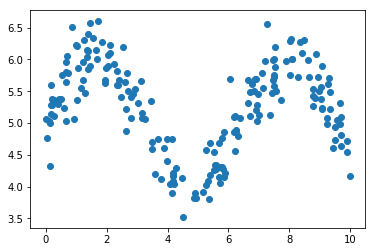

In [4]:
# Create fake data to test the mode

def produce_batch(batch_size, noise=0.3):
    xs = np.random.random(size=[batch_size, 1]) * 10
    ys = np.sin(xs) + 5 + np.random.normal(size=[batch_size, 1], scale=noise)
    return [xs.astype(np.float32), ys.astype(np.float32)]

# needs to run under with tf.Graph().as_default():
def convert_data_to_tensors(x, y):
    inputs = tf.constant(x)
    inputs.set_shape([None, 1])
    
    outputs = tf.constant(y)
    outputs.set_shape([None, 1])
    return inputs, outputs

x_train, y_train = produce_batch(200)
x_test, y_test = produce_batch(200)
plt.scatter(x_train, y_train)

I can run and the checkpoints will be save and I can change the learn rate and run again

In [48]:
# clean up checkppoints
!rm -vf tmp/regression_model/*

removed 'tmp/regression_model/checkpoint'
removed 'tmp/regression_model/events.out.tfevents.1557888667.leandroohf-VirtualBox'
removed 'tmp/regression_model/events.out.tfevents.1557888683.leandroohf-VirtualBox'
removed 'tmp/regression_model/graph.pbtxt'
removed 'tmp/regression_model/model.ckpt-0.data-00000-of-00001'
removed 'tmp/regression_model/model.ckpt-0.index'
removed 'tmp/regression_model/model.ckpt-0.meta'
removed 'tmp/regression_model/model.ckpt-10000.data-00000-of-00001'
removed 'tmp/regression_model/model.ckpt-10000.index'
removed 'tmp/regression_model/model.ckpt-10000.meta'
removed 'tmp/regression_model/model.ckpt-10001.data-00000-of-00001'
removed 'tmp/regression_model/model.ckpt-10001.index'
removed 'tmp/regression_model/model.ckpt-10001.meta'


In [64]:
# Train a model
ckpt_dir = 'tmp/regression_model/'

with tf.Graph().as_default():
    
    tf.logging.set_verbosity(tf.logging.INFO)
    
    inputs, targets = convert_data_to_tensors(x_train, y_train)

    # Make the model.
    predictions, nodes = regression_model(inputs, is_training=True)

    # Add the loss function to the graph.
    loss = tf.losses.mean_squared_error(labels=targets, predictions=predictions)
    
    # The total loss is the user's loss plus any regularization losses.
    total_loss =  tf.losses.get_total_loss()# slim.losses.get_total_loss()

    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0075)
    train_op = slim.learning.create_train_op(total_loss, optimizer) 

    # Run the training inside a session.
    final_loss = slim.learning.train(
        train_op,
        logdir=ckpt_dir,
        number_of_steps=5000,
        graph=graph,
        save_summaries_secs=5,
        log_every_n_steps=500)

print("Finished training. Last batch loss:", final_loss)
print("Checkpoint saved in %s" % ckpt_dir)

RuntimeError: Graph is finalized and cannot be modified.

In [50]:

with tf.Graph().as_default():
    
    tf.logging.set_verbosity(tf.logging.INFO)
    
    inputs, targets = convert_data_to_tensors(x_train, y_train)

    # Make the model.
    predictions, nodes = regression_model(inputs, is_training=True)

    # Add the loss function to the graph.
    loss = tf.losses.mean_squared_error(labels=targets, predictions=predictions)
    
    # The total loss is the user's loss plus any regularization losses.
    total_loss =  tf.losses.get_total_loss()# slim.losses.get_total_loss()

    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)
    train_op = slim.learning.create_train_op(total_loss, optimizer) 

    # Run the training inside a session.
    final_loss = slim.learning.train(
        train_op,
        logdir=ckpt_dir,
        number_of_steps=5000 + 5000,
        save_summaries_secs=5,
        log_every_n_steps=500)

print("Finished training. Last batch loss:", final_loss)
print("Checkpoint saved in %s" % ckpt_dir)

INFO:tensorflow:Restoring parameters from tmp/regression_model/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path tmp/regression_model/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global step 5500: loss = 0.1758 (0.001 sec/step)
INFO:tensorflow:global step 6000: loss = 0.1823 (0.000 sec/step)
INFO:tensorflow:global step 6500: loss = 0.1713 (0.000 sec/step)
INFO:tensorflow:global step 7000: loss = 0.1742 (0.000 sec/step)
INFO:tensorflow:global step 7500: loss = 0.1785 (0.000 sec/step)
INFO:tensorflow:global step 8000: loss = 0.1751 (0.000 sec/step)
INFO:tensorflow:global step 8500: loss = 0.1752 (0.001 sec/step)
INFO:tensorflow:global step 9000: loss = 0.1811 (0.000 sec/step)
INFO:tensorflow:global step 9500: loss = 0.1850 (0.001 sec/step)
INFO:tensorflow:global step 10000: loss = 0.1825 (0.001 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensor

In [51]:
!ls tmp/regression_model

checkpoint
events.out.tfevents.1557888702.leandroohf-VirtualBox
events.out.tfevents.1557888710.leandroohf-VirtualBox
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-10000.data-00000-of-00001
model.ckpt-10000.index
model.ckpt-10000.meta
model.ckpt-5000.data-00000-of-00001
model.ckpt-5000.index
model.ckpt-5000.meta


#### Test

INFO:tensorflow:Restoring parameters from tmp/regression_model/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path tmp/regression_model/model.ckpt
INFO:tensorflow:Starting queue runners.


Text(0.5,1,'red=true, blue=predicted')

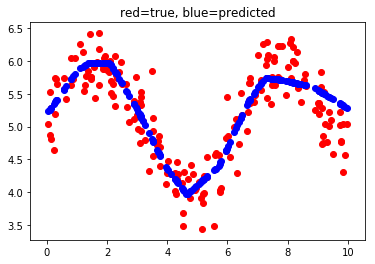

In [52]:
# do a prediction

with tf.Graph().as_default():
    inputs, targets = convert_data_to_tensors(x_test, y_test)
  
    # Create the model structure. (Parameters will be loaded below.)
    predictions, end_points = regression_model(inputs, is_training=False)

    # Make a session which restores the old parameters from a checkpoint.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        inputs, predictions, targets = sess.run([inputs, predictions, targets])

plt.scatter(inputs, targets, c='r');
plt.scatter(inputs, predictions, c='b');
plt.title('red=true, blue=predicted')

#### Evaluation model

TODO: NOT working Is hard or complicated to work with

You have to run the script in parallel

In [61]:
log_dir = 'tmp/log'

# Choose the metrics to compute:
names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
    'RMSE Linear': slim.metrics.streaming_mean_squared_error(predictions=predictions, labels=targets),
    'Mean Abs Error': slim.metrics.streaming_mean_absolute_error(predictions, targets)
})


# Create the summary ops such that they also print out to std output:
summary_ops = []
for metric_name, metric_value in names_to_values.items():
     
    op = tf.summary.scalar(metric_name, metric_value)
    op = tf.Print(op, [metric_value], metric_name)
    summary_ops.append(op)

num_examples = 10000
batch_size = 32
num_batches = math.ceil(num_examples / float(batch_size))

# Setup the global step.
slim.get_or_create_global_step()

output_dir = 'tmp/regression_model/' # Where the summaries are stored.
eval_interval_secs = 0.5 # How often to run the evaluation.

slim.evaluation.evaluation_loop(
    'local',
    ckpt_dir,
    log_dir,
    num_evals=num_batches,
    eval_op=names_to_updates.values(),
    summary_op=tf.summary.merge(summary_ops),
    eval_interval_secs=eval_interval_secs)

INFO:tensorflow:Summary name RMSE Linear is illegal; using RMSE_Linear instead.
INFO:tensorflow:Summary name Mean Abs Error is illegal; using Mean_Abs_Error instead.
INFO:tensorflow:Waiting for new checkpoint at tmp/regression_model/
INFO:tensorflow:Found new checkpoint at tmp/regression_model/model.ckpt
INFO:tensorflow:Graph was finalized.


NotFoundError: No session factory registered for the given session options: {target: "local" config: } Registered factories are {DIRECT_SESSION, GRPC_SESSION}.

### Convolutional (TODO)

In [65]:
from datasets import flowers

ModuleNotFoundError: No module named 'datasets'

In [ ]:
def my_cnn(images, num_classes, is_training):  # is_training is not used...
    
    with slim.arg_scope([slim.max_pool2d], kernel_size=[3, 3], stride=2):
        net = slim.conv2d(images, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.conv2d(net, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.flatten(net)
        net = slim.fully_connected(net, 192)
        net = slim.fully_connected(net, num_classes, activation_fn=None)       
    return net


**Apply the model to some randomly generated images.**

In [68]:
import tensorflow as tf

with tf.Graph().as_default():
    # The model can handle any input size because the first layer is convolutional.
    # The size of the model is determined when image_node is first passed into the my_cnn function.
    # Once the variables are initialized, the size of all the weight matrices is fixed.
    # Because of the fully connected layers, this means that all subsequent images must have the same
    # input size as the first image.
    batch_size, height, width, channels = 3, 28, 28, 3
    images = tf.random_uniform([batch_size, height, width, channels], maxval=1)
    
    # Create the model.
    num_classes = 10
    logits = my_cnn(images, num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
  
    # Initialize all the variables (including parameters) randomly.
    init_op = tf.global_variables_initializer()
  
    with tf.Session() as sess:
        # Run the init_op, evaluate the model outputs and print the results:
        sess.run(init_op)
        probabilities = sess.run(probabilities)
        
print('Probabilities Shape:')
print(probabilities.shape)  # batch_size x num_classes 

print('\nProbabilities:')
print(probabilities)

print('\nSumming across all classes (Should equal 1):')
print(np.sum(probabilities, 1)) # Each row sums to 1

Probabilities Shape:
(3, 10)

Probabilities:
[[0.12117468 0.13987829 0.08556061 0.08082899 0.10685908 0.10058352
  0.1032743  0.0668804  0.09540402 0.09955609]
 [0.1188206  0.1384214  0.09035526 0.08674826 0.1045357  0.09944606
  0.10172102 0.06792291 0.09420499 0.09782375]
 [0.12074974 0.14131087 0.08615983 0.08685173 0.10640257 0.09827081
  0.0992412  0.06986367 0.0920784  0.09907109]]

Summing across all classes (Should equal 1):
[1.        1.        0.9999999]


## Keras 